# Exercises - Part 1

As a customer analyst for Telco, you want to know who has spent the most money with the company over their lifetime. You have monthly charges and tenure, so you think you will be able to use those two attributes as features to estimate total charges. You need to do this within an average of $5.00 per customer.

In these exercises, you will run through the stages of exploration as you continue to work toward the above goal.

Do your work in a notebook named explore.ipynb. In addition, you should create a file named explore.py that contains the following functions for exploring your variables (features & target).

__Step 1__

Make sure to perform a train, validate, test split before and use only your train dataset to explore the relationships between independent variables with other independent variables or independent variables with your target variable.

In [1]:
import numpy as np
import pandas as pd
import os
import env
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split

In [2]:
#Acquire the telco data
def get_sql_url(database):
    return f'mysql+pymysql://{env.user}:{env.password}@{env.host}/{database}'

def get_telco_data():
    file_name = 'telco.csv'

    if os.path.isfile(file_name):
        return pd.read_csv(file_name)
    else:
        df = pd.read_sql("""SELECT * FROM customers 
                            JOIN contract_types ON contract_types.contract_type_id = customers.contract_type_id
                            JOIN internet_service_types ON internet_service_types.internet_service_type_id = customers.internet_service_type_id
                            JOIN payment_types ON payment_types.payment_type_id = customers.payment_type_id;""", get_sql_url('telco_churn'))
        df.to_csv(file_name, index = False)

        return df
    
#Prepare the telco data
def yes_or_no(value):
    if value == 1:
        return 'Yes'
    elif value == 0:
        return 'No'

#The following function will be used in the prep functions to return the train, validate, and test splits
def train_validate_test_split(df, target, seed = 123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

def prep_without_encoding(telco):
    telco.drop_duplicates(inplace = True)

    #Only use rows where tenure is greater than zero
    telco = telco[telco.tenure > 0].copy()

    #Convert total_charges to float
    telco.total_charges = telco.total_charges.str.strip()
    telco.total_charges = telco.total_charges.str.replace('[$,]','', regex = True)
    telco.total_charges = telco.total_charges.astype(float)

    #Select all categorical columns (ignoring customer_id since it will be dropped)
    cat_cols = telco.select_dtypes('object').columns

    #Strip all leading and trailing whitespace from each categorical column
    for col in cat_cols:
        telco[col] = telco[col].str.strip()

    #drop unnecessary columns
    telco.drop(columns = ['internet_service_type_id', 'contract_type_id', 'payment_type_id', 'contract_type_id.1', 'internet_service_type_id.1', 'payment_type_id.1'], inplace = True)

    #For the explore stage, I want my categorical values to be easy to read.
    #So I will convert the senior_citizen column to 'object' datatype and change its values to 'yes' or 'no'.
    telco.senior_citizen = telco.senior_citizen.astype(object)
    telco.senior_citizen = telco.senior_citizen.apply(yes_or_no)

    return train_validate_test_split(telco, 'churn')

In [3]:
telco = get_telco_data()
telco.head()

customer_id  gender  senior_citizen partner dependents  tenure  \
0  0016-QLJIS  Female               0     Yes        Yes      65   
1  0017-DINOC    Male               0      No         No      54   
2  0019-GFNTW  Female               0      No         No      56   
3  0056-EPFBG    Male               0     Yes        Yes      20   
4  0078-XZMHT    Male               0     Yes         No      72   

  phone_service    multiple_lines  internet_service_type_id online_security  \
0           Yes               Yes                         1             Yes   
1            No  No phone service                         1             Yes   
2            No  No phone service                         1             Yes   
3            No  No phone service                         1             Yes   
4           Yes               Yes                         1              No   

   ... payment_type_id monthly_charges total_charges churn contract_type_id.1  \
0  ...               2           90.45        5957.9    No                  3   
1  ...               4           45.20       2460.55    No                  3   
2  ...               3           45.05        2560.1    No                  3   
3  ...               4           39.40         825.4    No                  3   
4  ...               3           85.15        6316.2    No                  3   

   contract_type internet_service_type_id.1  internet_service_type  \
0       Two year                          1                    DSL   
1       Two year                          1                    DSL   
2       Two year                          1                    DSL   
3       Two year                          1                    DSL   
4       Two year                          1                    DSL   

   payment_type_id.1               payment_type  
0                  2               Mailed check  
1                  4    Credit card (automatic)  
2                  3  Bank transfer (automatic)  
3                  4    Credit card (automatic)  
4                  3  Bank transfer (automatic)  

[5 rows x 27 columns]

In [4]:
train, validate, test = prep_without_encoding(telco)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3937 entries, 6096 to 3935
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            3937 non-null   object 
 1   gender                 3937 non-null   object 
 2   senior_citizen         3937 non-null   object 
 3   partner                3937 non-null   object 
 4   dependents             3937 non-null   object 
 5   tenure                 3937 non-null   int64  
 6   phone_service          3937 non-null   object 
 7   multiple_lines         3937 non-null   object 
 8   online_security        3937 non-null   object 
 9   online_backup          3937 non-null   object 
 10  device_protection      3937 non-null   object 
 11  tech_support           3937 non-null   object 
 12  streaming_tv           3937 non-null   object 
 13  streaming_movies       3937 non-null   object 
 14  paperless_billing      3937 non-null   object 
 15  m

__Step 2__

Write a function named plot_variable_pairs that accepts a dataframe as input and plots all of the pairwise relationships along with the regression line for each pair.

In [6]:
#Seaborn pairplot can do this, so I'll just write a funciton that utilizes that
def get_pairwise_charts(df):
    sns.pairplot(df, kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})
    plt.show()

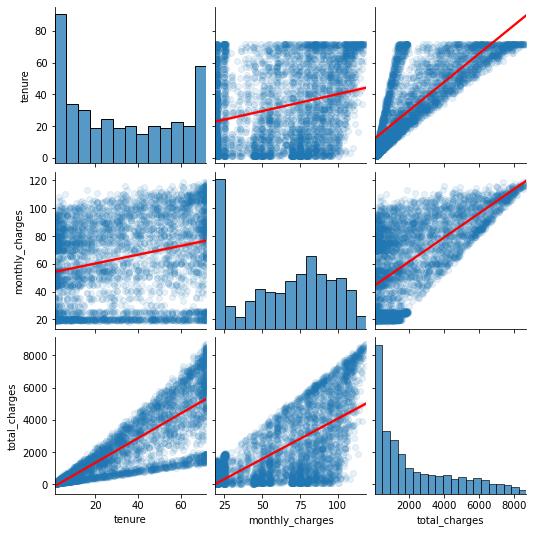

In [7]:
get_pairwise_charts(train)

__Step 3__

Write a function named months_to_years that accepts your telco churn dataframe and returns a dataframe with a new feature tenure_years, in complete years as a customer.

In [8]:
def months_to_years(df):
    df['tenure_years'] = round(df.tenure / 12, 0)
    return df

In [9]:
train = months_to_years(train)
train.head()

customer_id  gender senior_citizen partner dependents  tenure  \
6096  8966-SNIZF  Female             No     Yes         No      70   
1603  3466-BYAVD    Male             No     Yes        Yes      15   
5350  9278-VZKCD  Female            Yes     Yes         No      52   
2068  7074-STDCN    Male             No      No         No      39   
6366  5914-GXMDA  Female             No     Yes         No      32   

     phone_service    multiple_lines      online_security  \
6096           Yes                No  No internet service   
1603           Yes                No                   No   
5350           Yes               Yes                  Yes   
2068            No  No phone service                   No   
6366           Yes                No  No internet service   

            online_backup  ...         streaming_tv     streaming_movies  \
6096  No internet service  ...  No internet service  No internet service   
1603                  Yes  ...                   No                  Yes   
5350                  Yes  ...                  Yes                  Yes   
2068                   No  ...                   No                  Yes   
6366  No internet service  ...  No internet service  No internet service   

     paperless_billing monthly_charges total_charges  churn   contract_type  \
6096                No           19.45       1303.50     No        Two year   
1603               Yes           69.50       1071.40     No  Month-to-month   
5350               Yes          109.10       5647.95     No  Month-to-month   
2068               Yes           40.60       1494.50     No  Month-to-month   
6366                No           19.30        593.20     No        One year   

     internet_service_type               payment_type tenure_years  
6096                  None  Bank transfer (automatic)          6.0  
1603                   DSL               Mailed check          1.0  
5350           Fiber optic           Electronic check          4.0  
2068                   DSL           Electronic check          3.0  
6366                  None               Mailed check          3.0  

[5 rows x 22 columns]

__Step 4__

Write a function named plot_categorical_and_continuous_vars that accepts your dataframe and the name of the columns that hold the continuous and categorical features and outputs 3 different plots for visualizing a categorical variable and a continuous variable.

In [10]:
#create lists of categorical and numerical columns
cat_cols = train.select_dtypes('object').columns[1:]
num_cols = ['tenure', 'monthly_charges', 'total_charges', 'tenure_years']

In [11]:
#import itertools
from itertools import combinations
from itertools import product

import warnings
warnings.filterwarnings("ignore")

In [12]:
#I take the problem to mean create a function that produces 3 different graphs for each
#combination of categorical and numerical columns
def plot_categorical_and_continuous_vars(df, cat_cols, num_cols):
    vars_to_chart = list(product(cat_cols, num_cols))
    
    for pair in vars_to_chart:
        #Fit the three related graphs in one row
        sns.set(rc={"figure.figsize":(10, 6)}) #width=10, height=6
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        
        plot1 = sns.stripplot(x=pair[0], y=pair[1], ax = ax1, data=df)
        plot1.set_xticklabels(plot1.get_xticklabels(), rotation = 45)
        
        plot2 = sns.boxplot(x=pair[0], y=pair[1], ax = ax2, data=df)
        plot2.set_xticklabels(plot2.get_xticklabels(), rotation = 45)
        
        plot3 = sns.violinplot(x=pair[0], y=pair[1], ax = ax3, data=df)
        plot3.set_xticklabels(plot3.get_xticklabels(), rotation = 45)
        
        plt.tight_layout()
        plt.show()


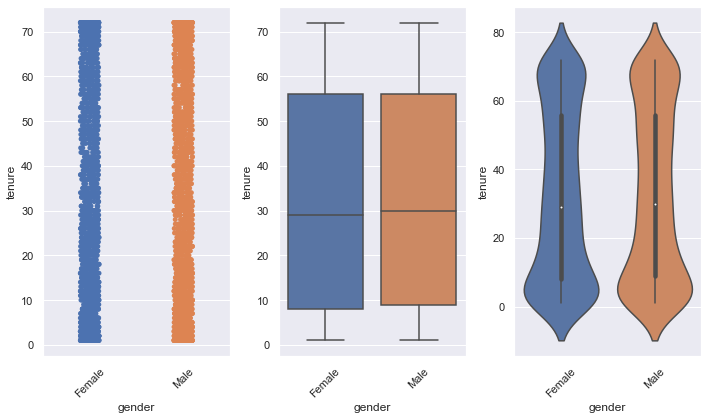

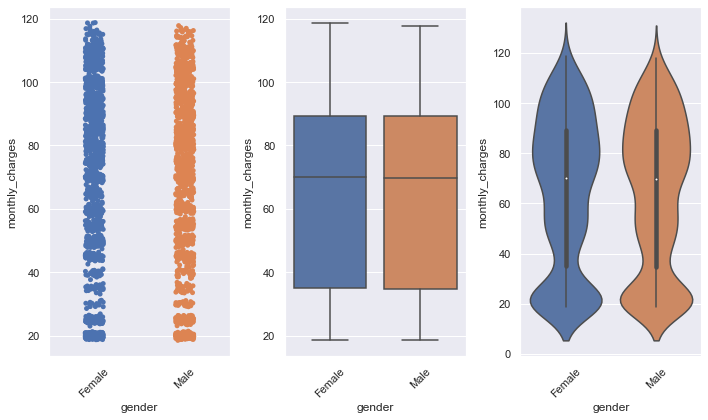

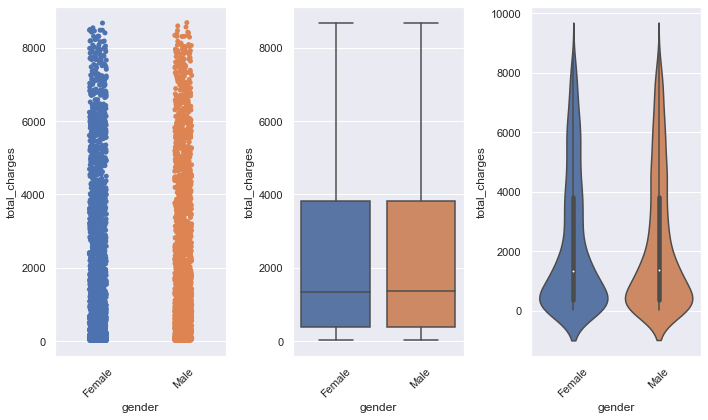

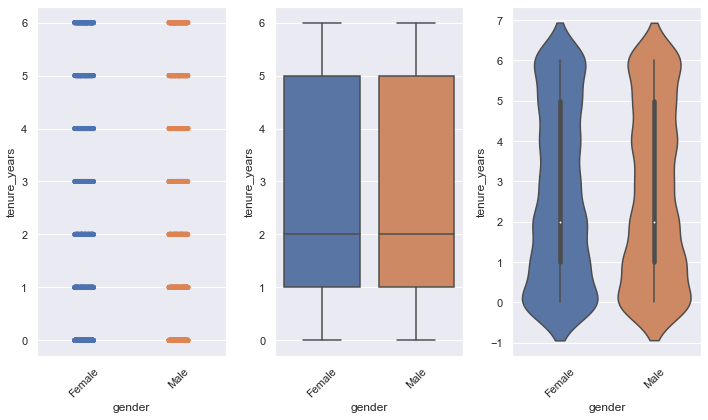

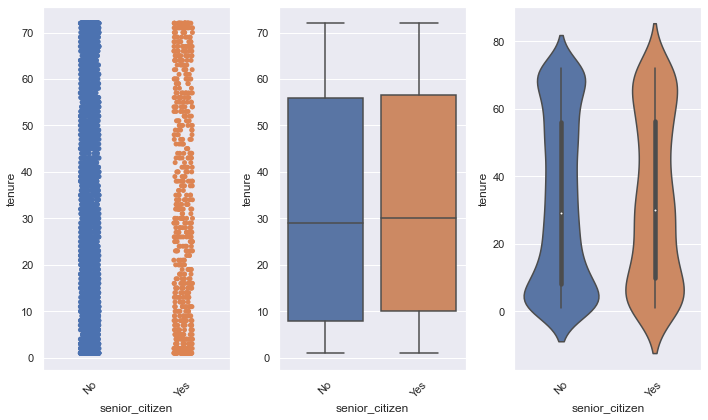

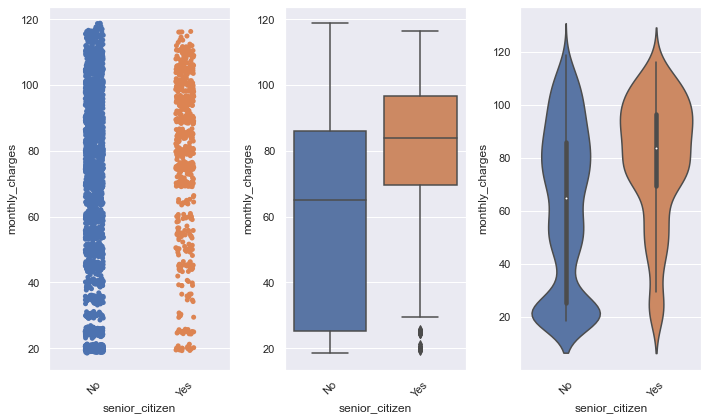

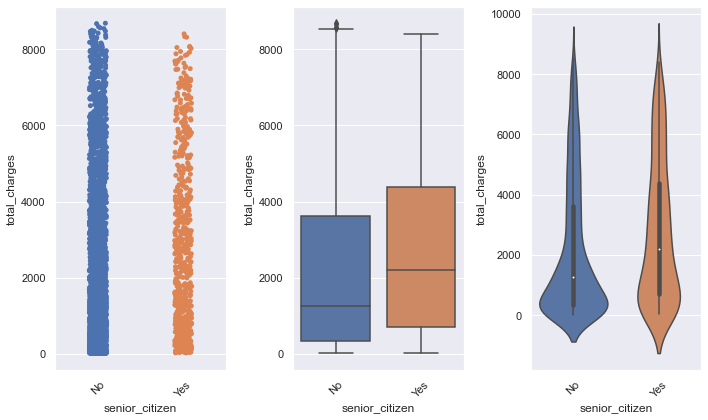

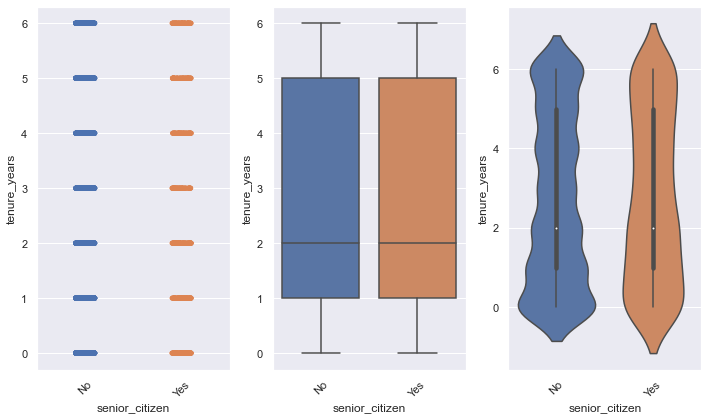

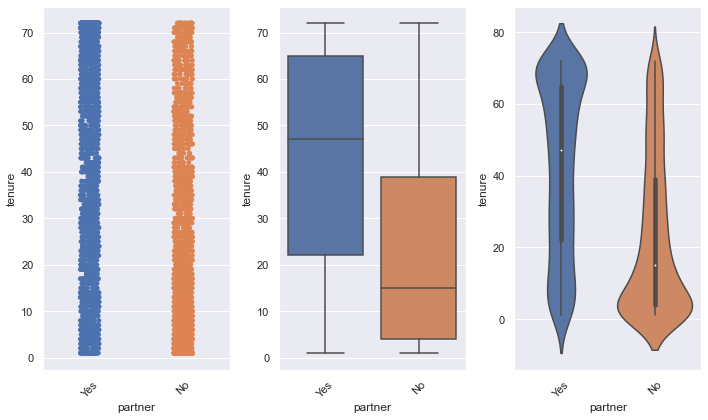

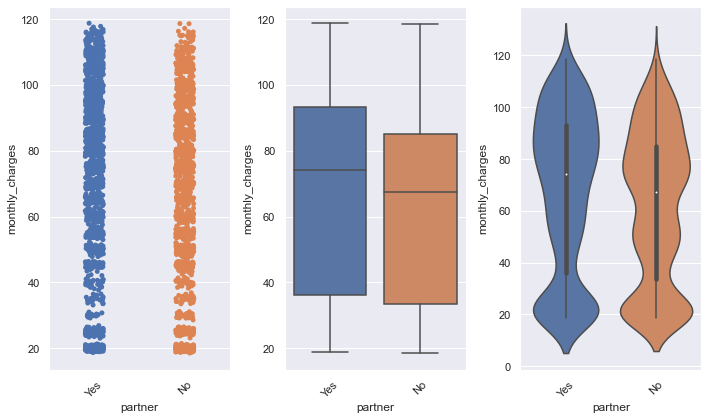

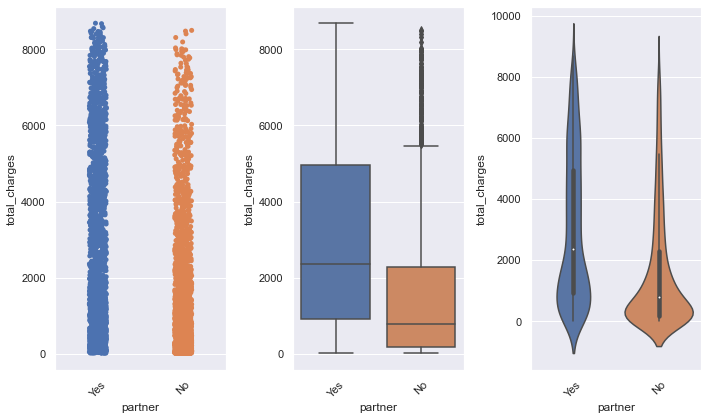

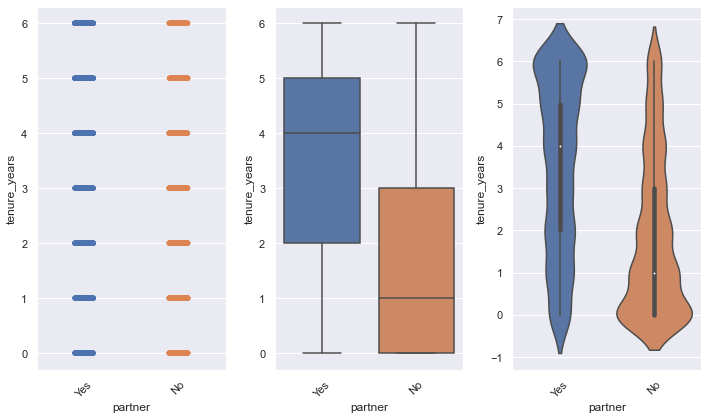

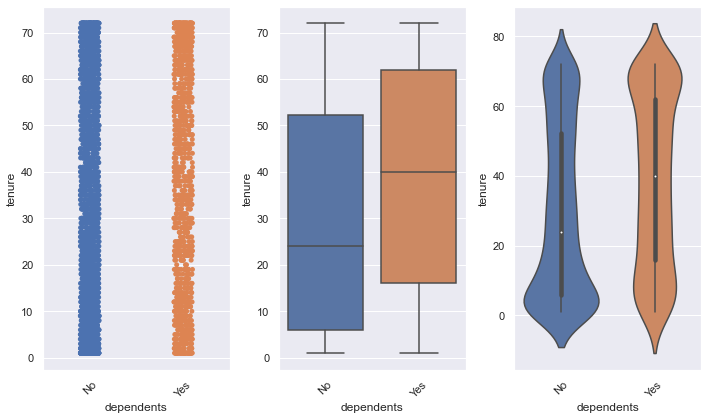

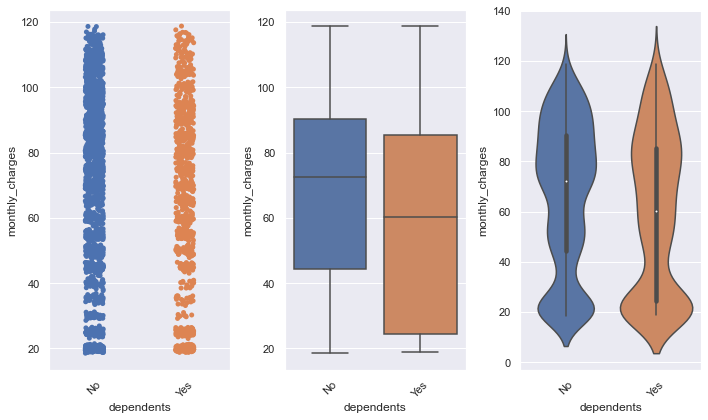

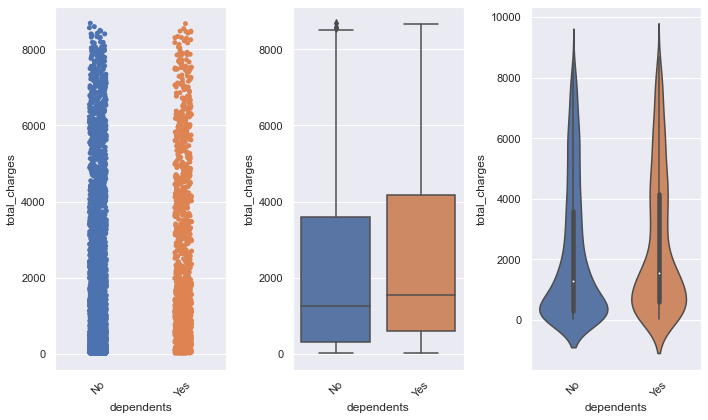

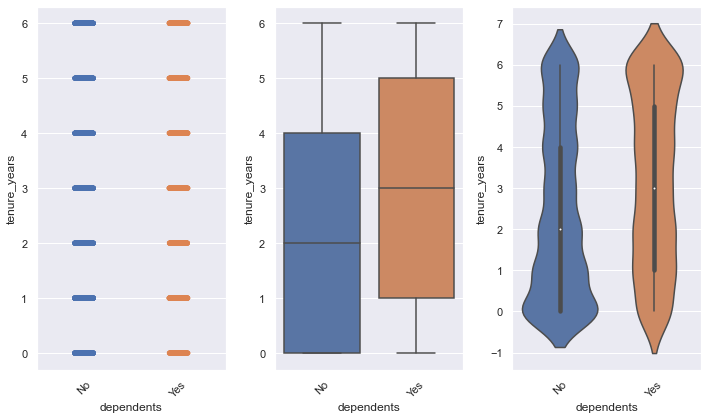

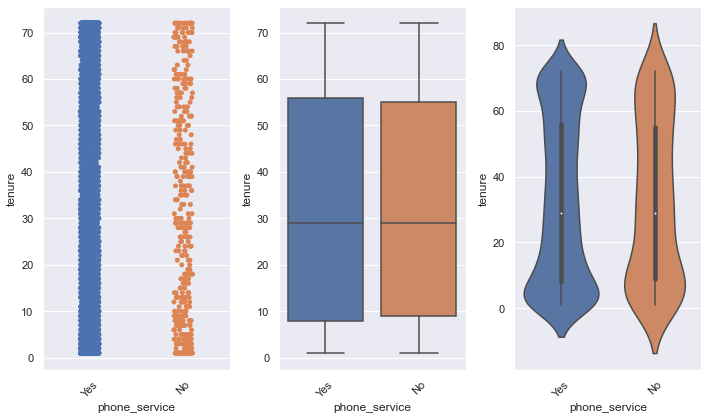

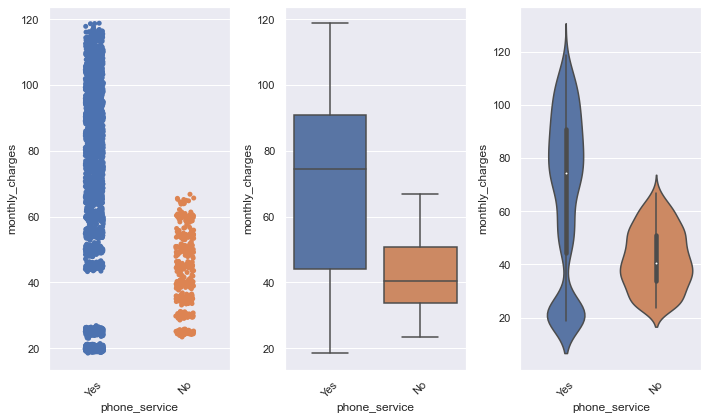

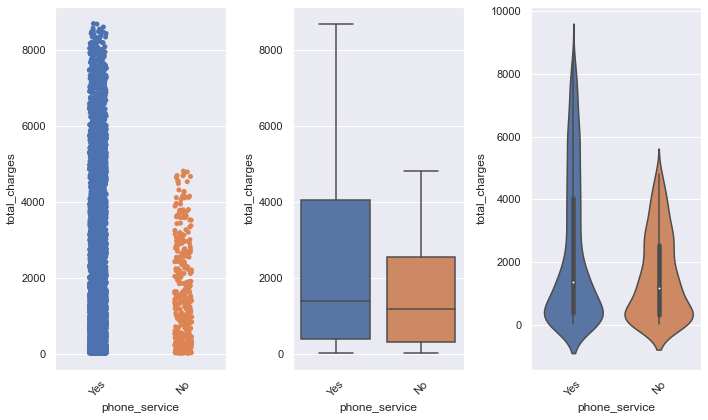

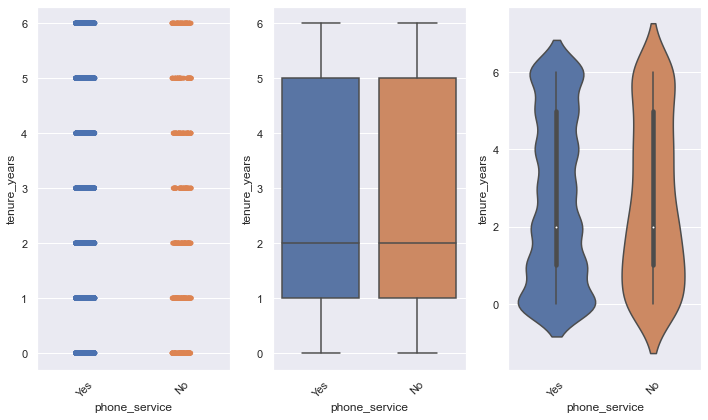

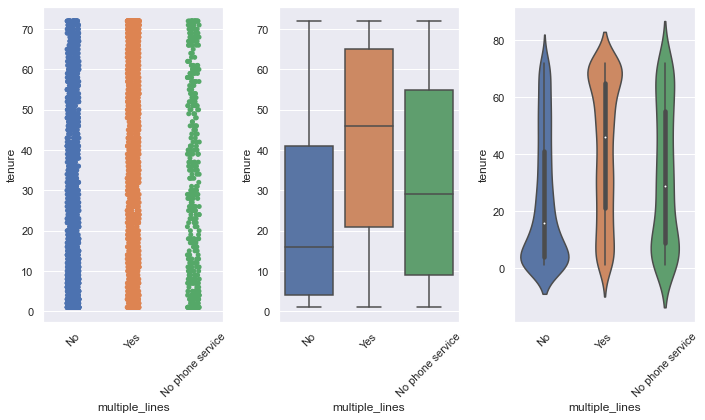

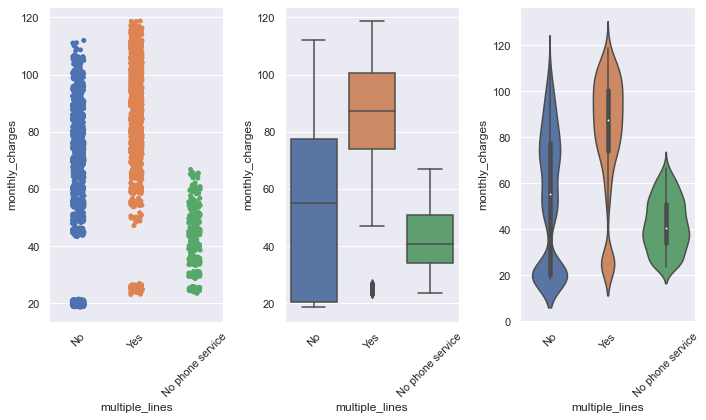

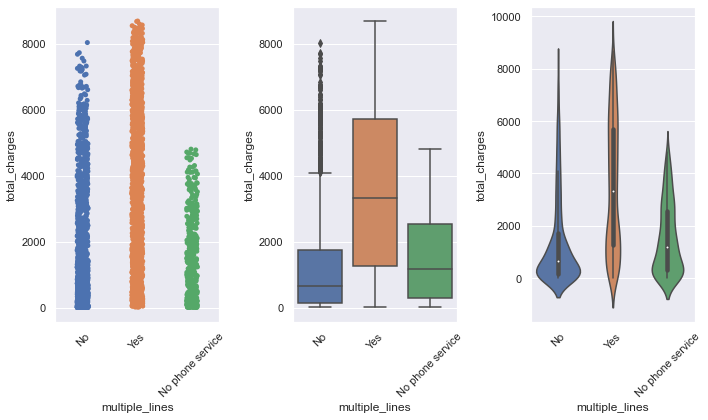

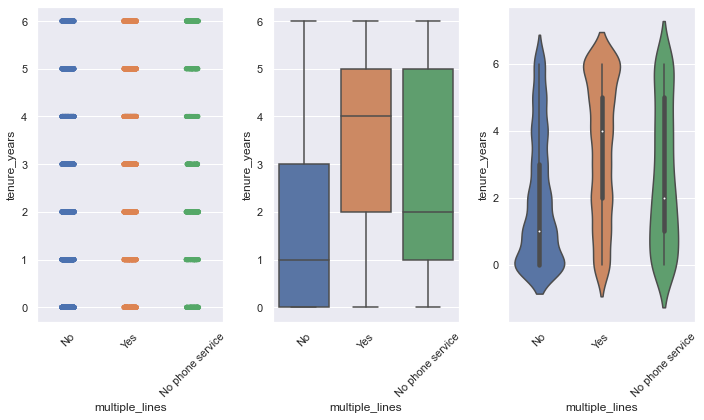

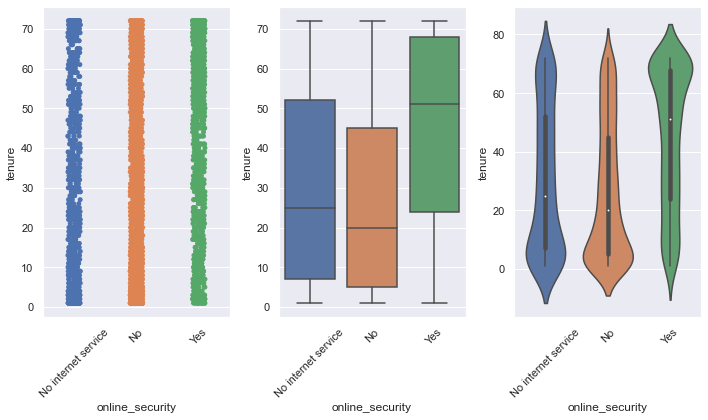

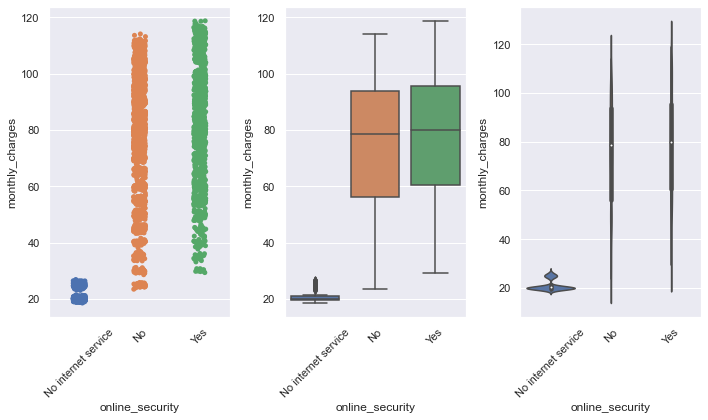

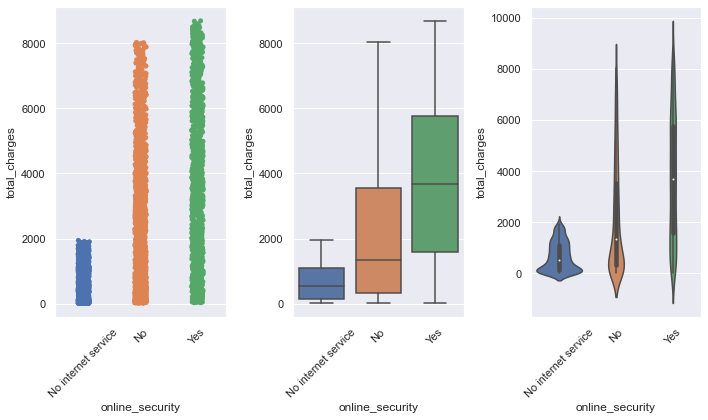

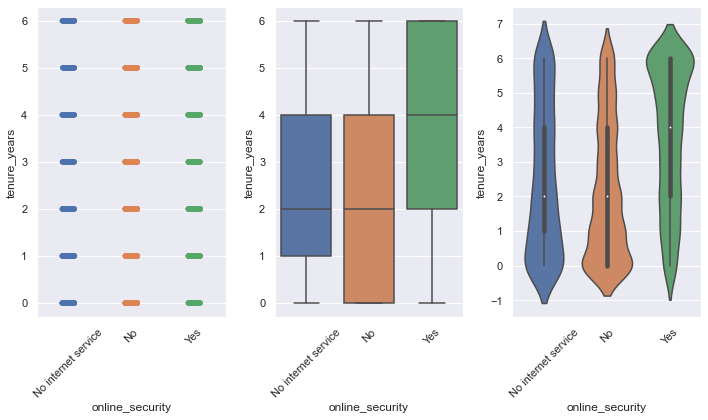

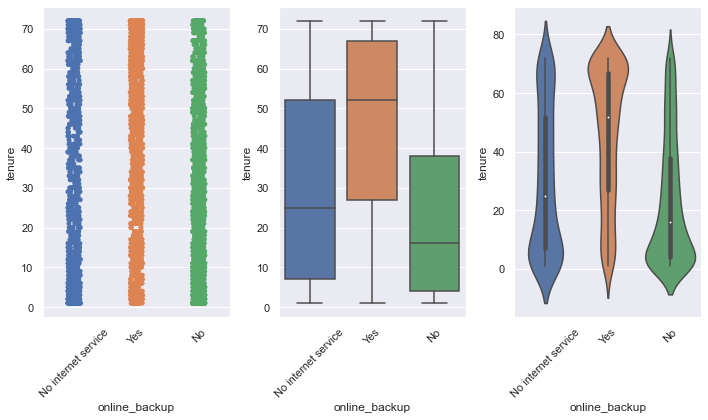

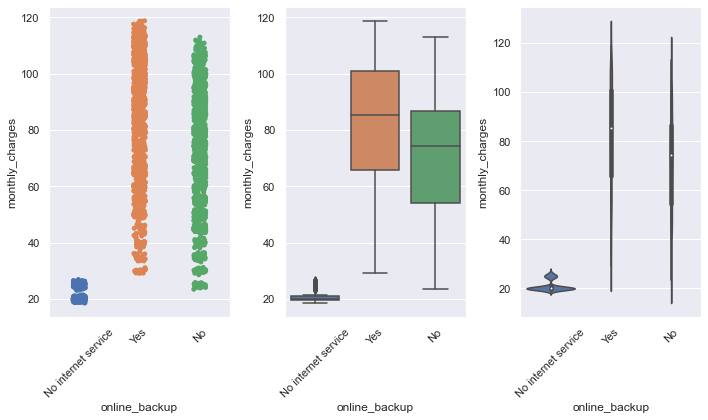

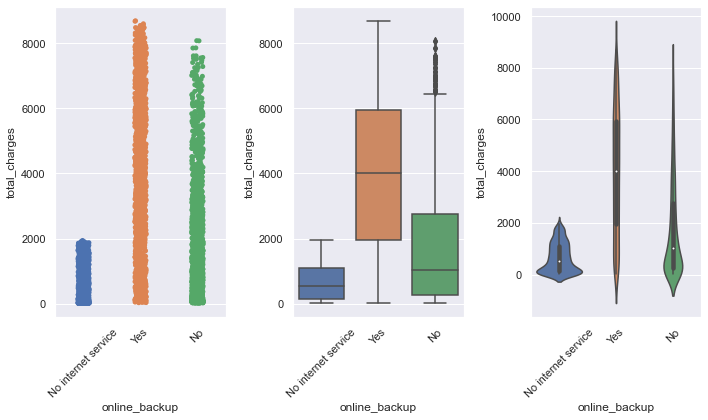

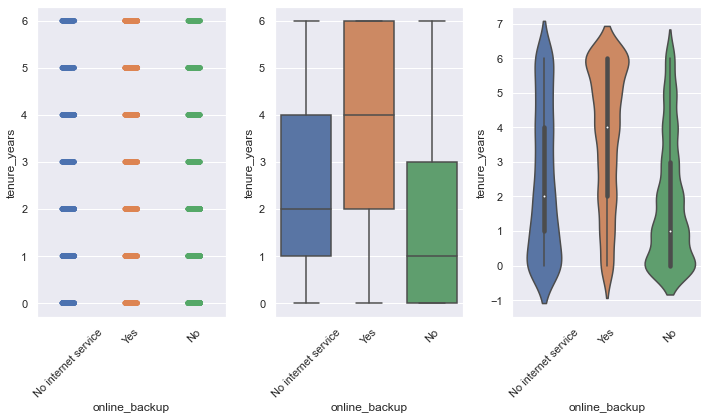

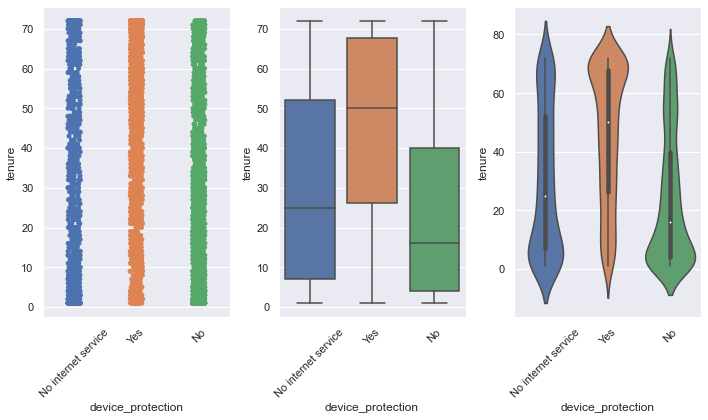

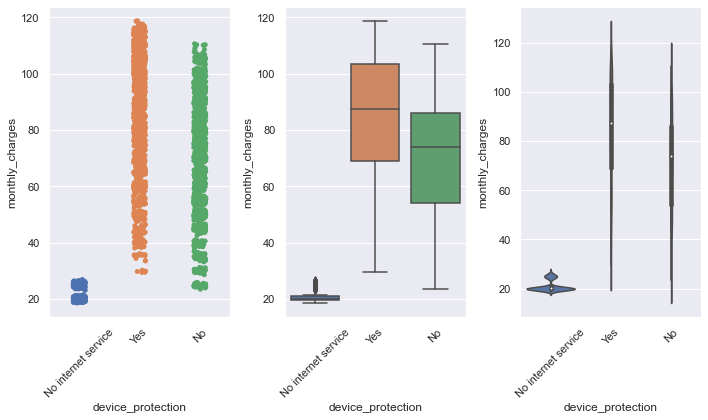

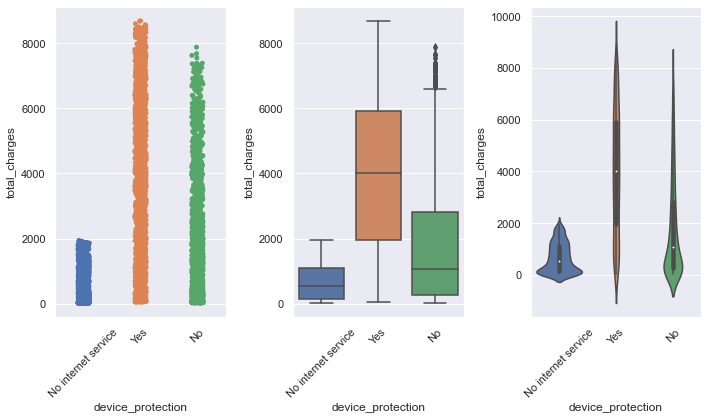

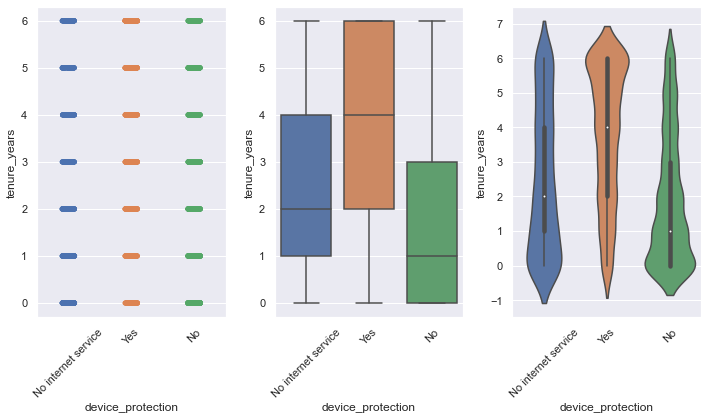

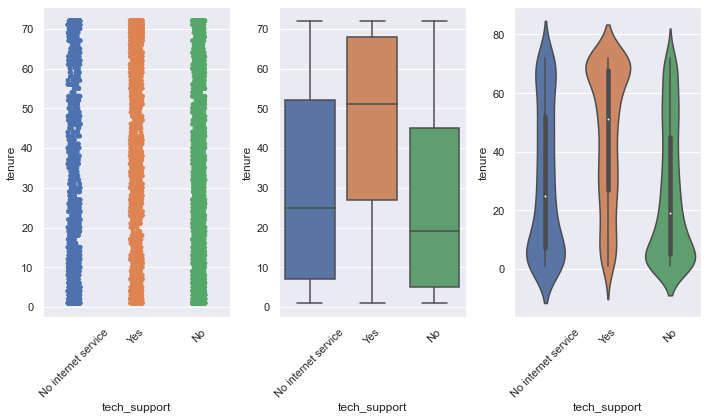

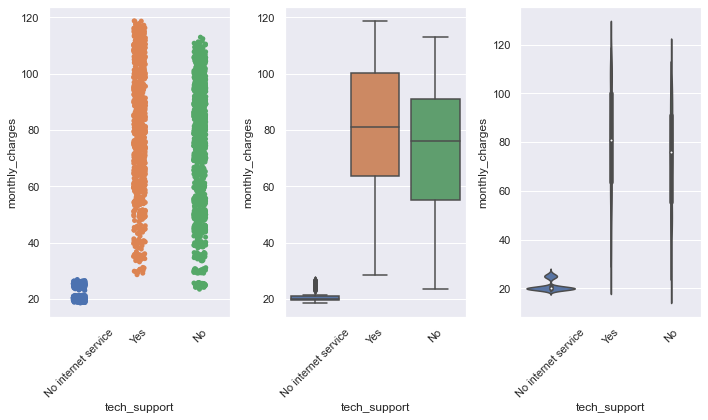

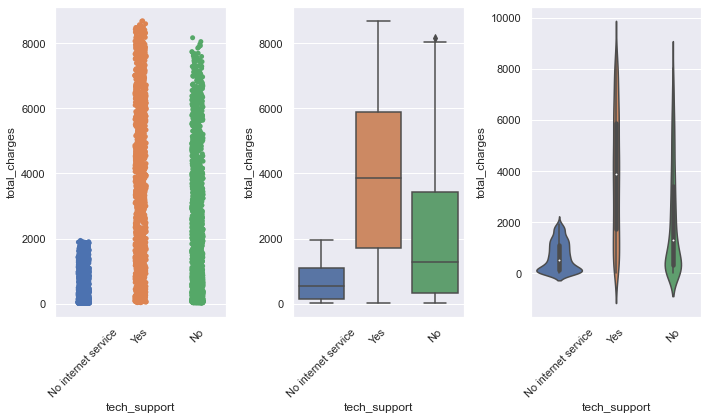

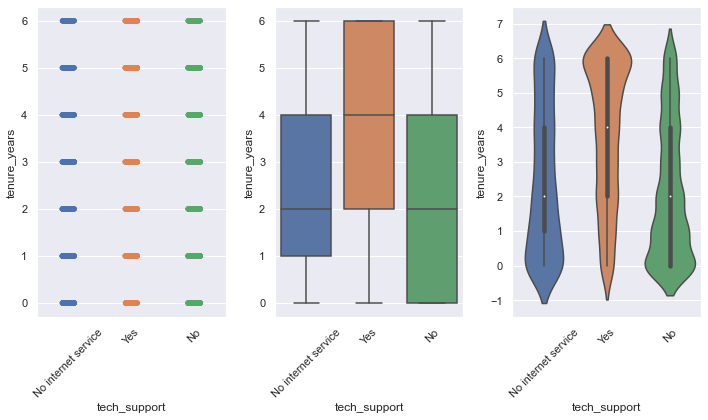

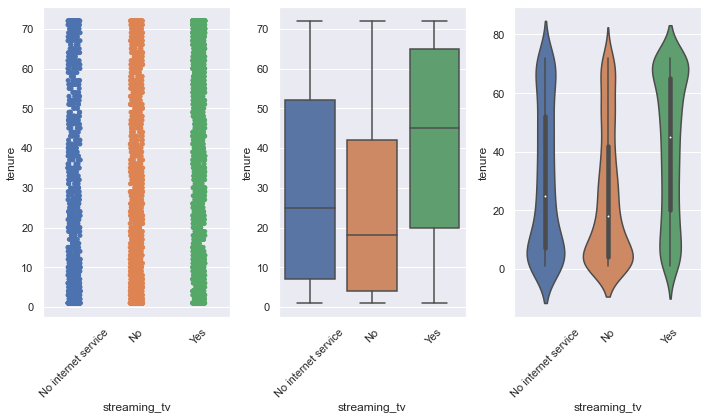

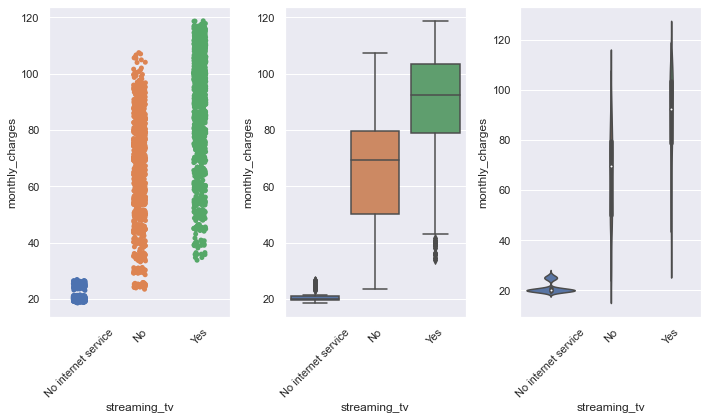

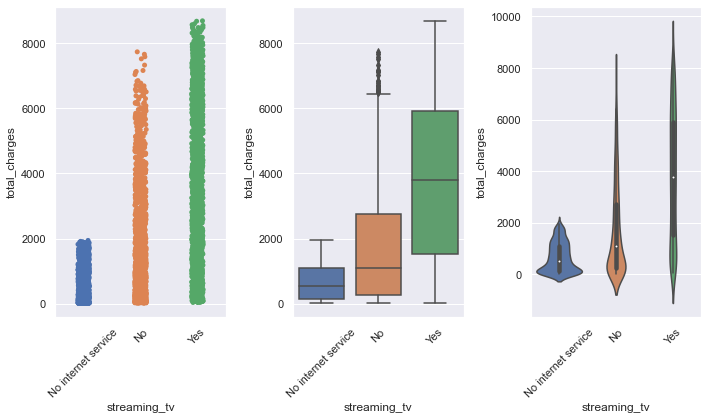

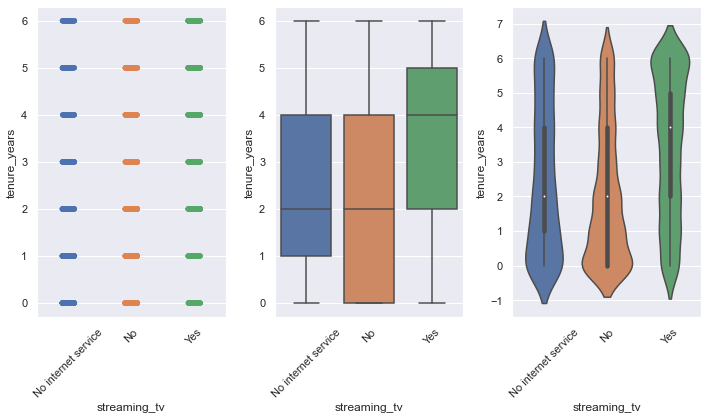

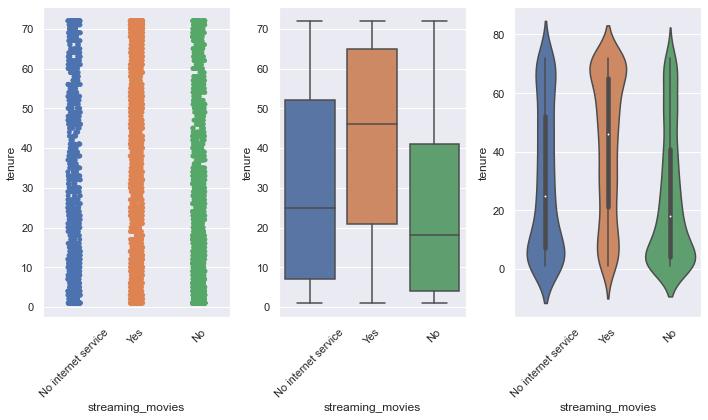

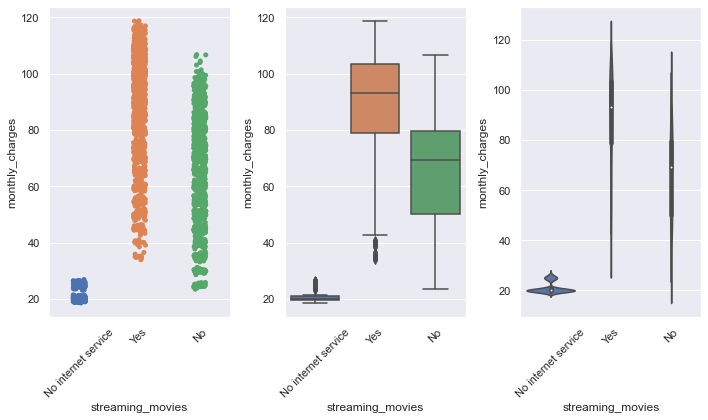

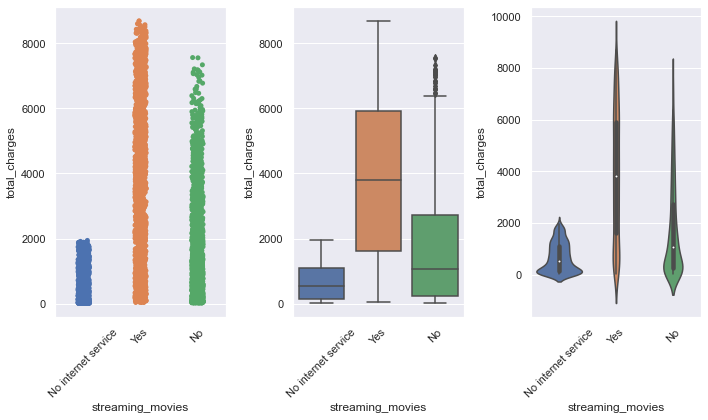

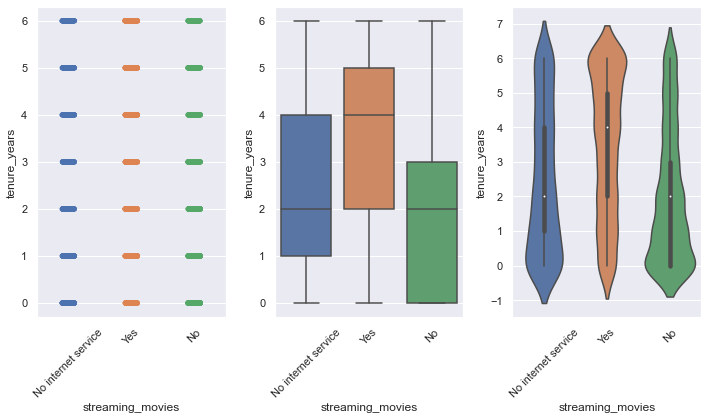

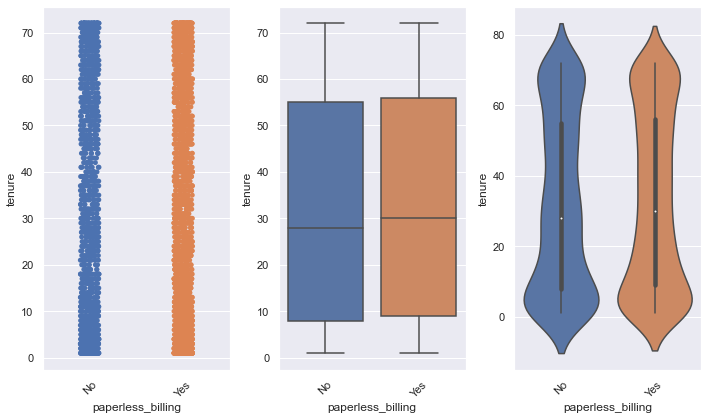

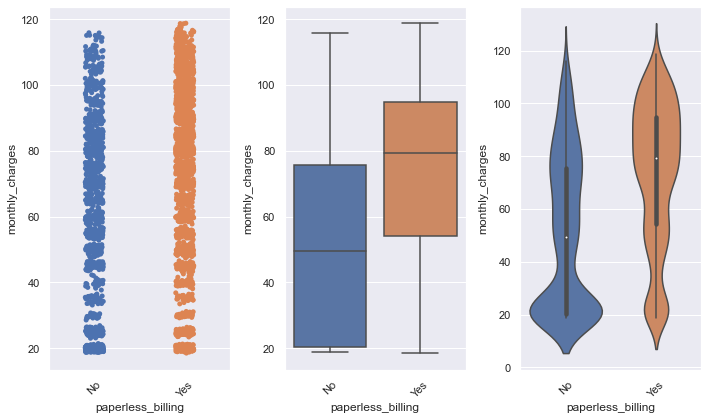

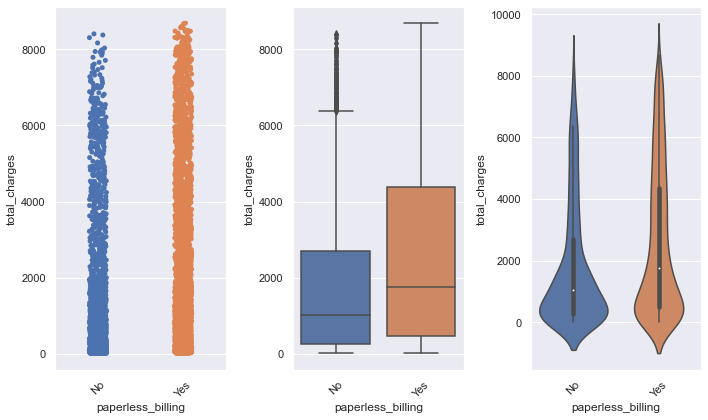

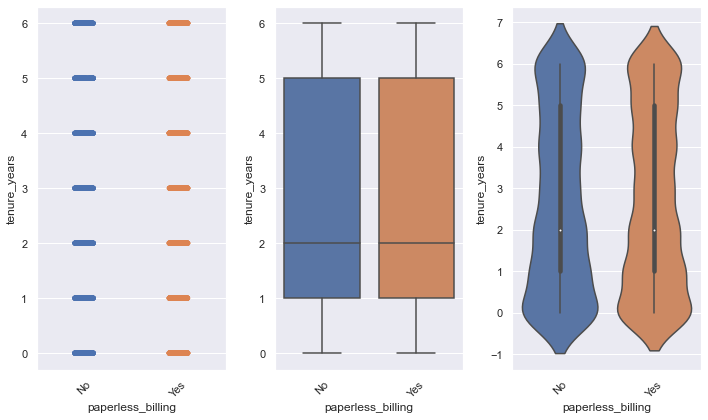

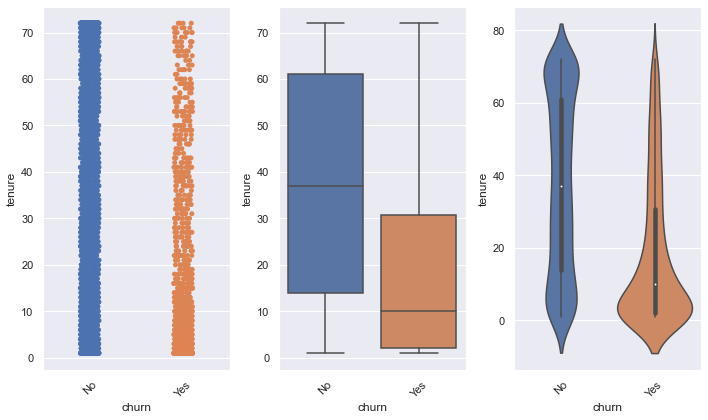

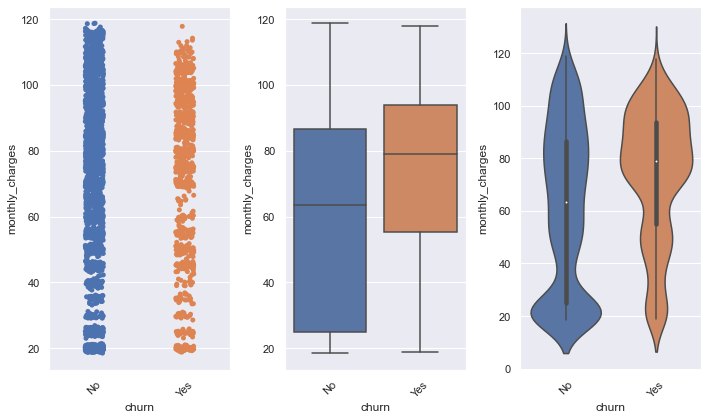

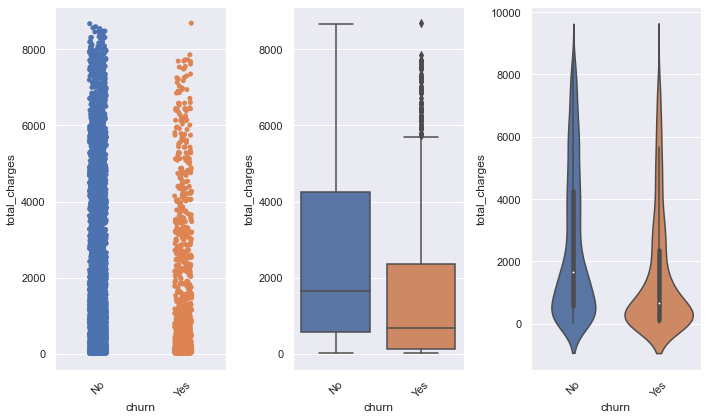

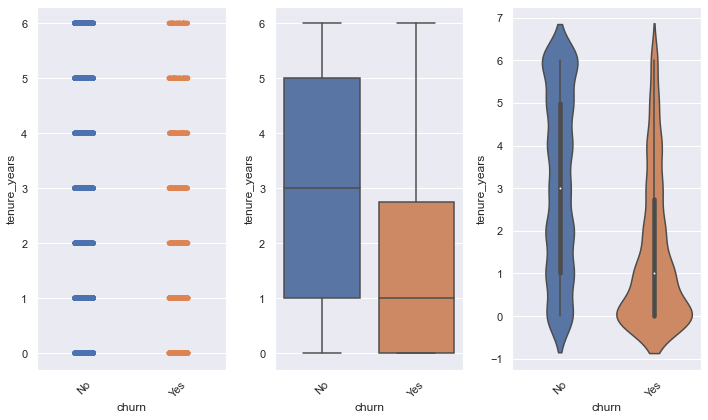

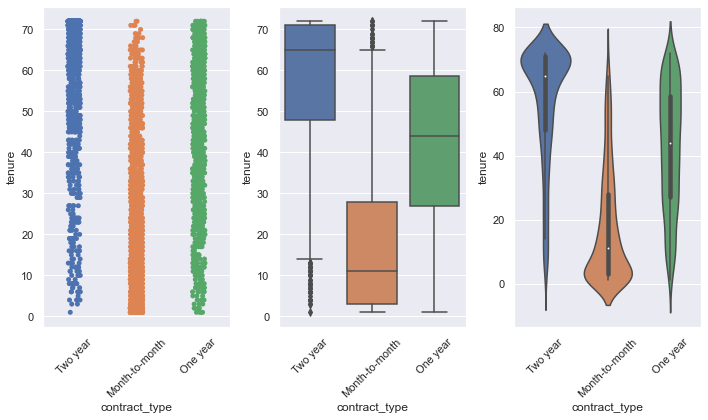

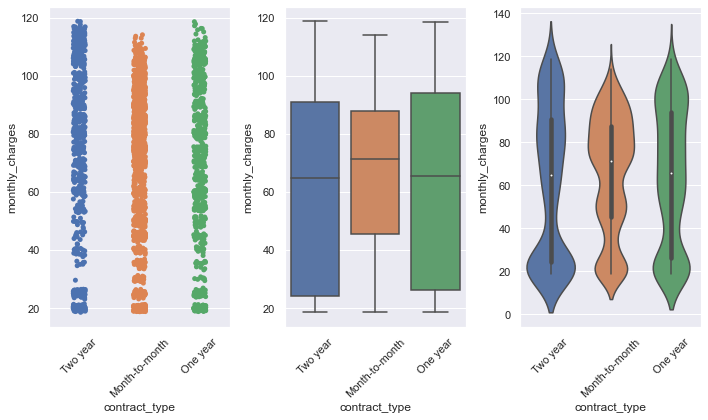

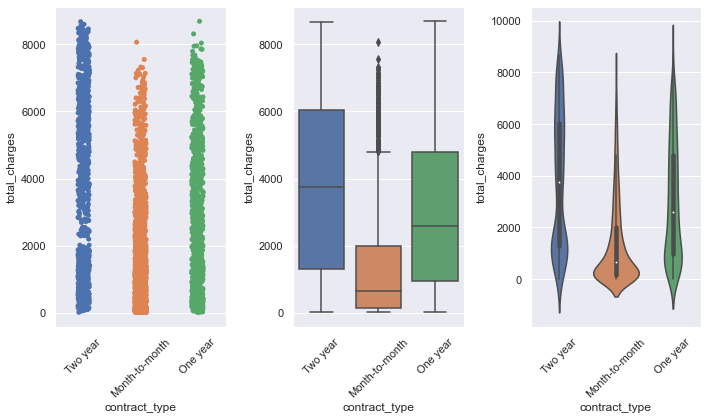

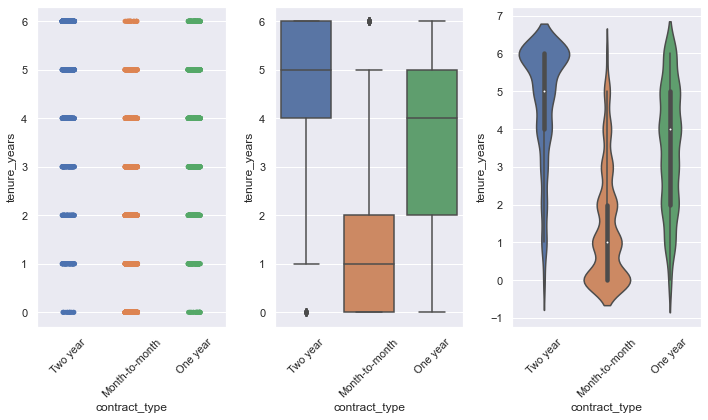

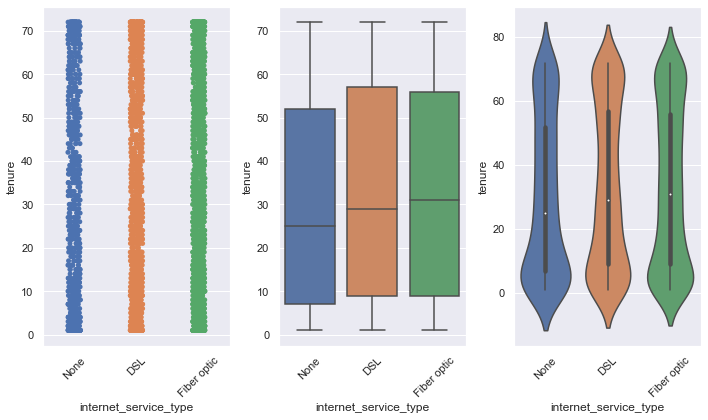

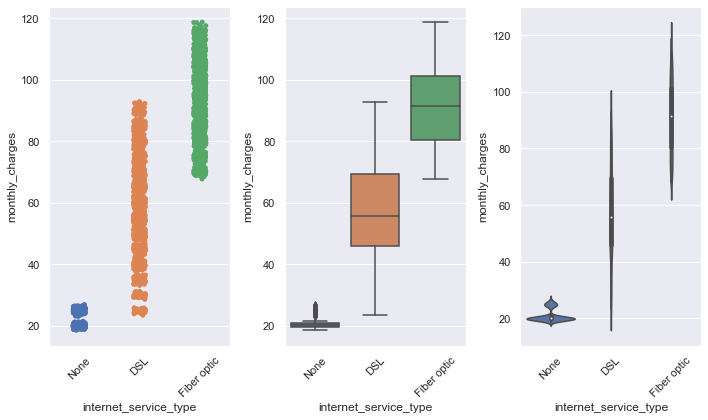

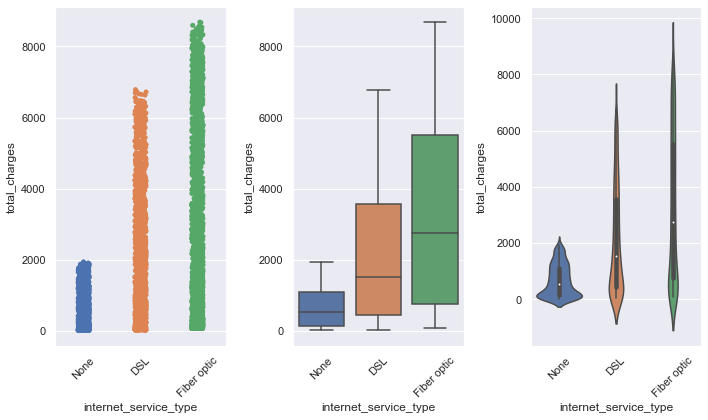

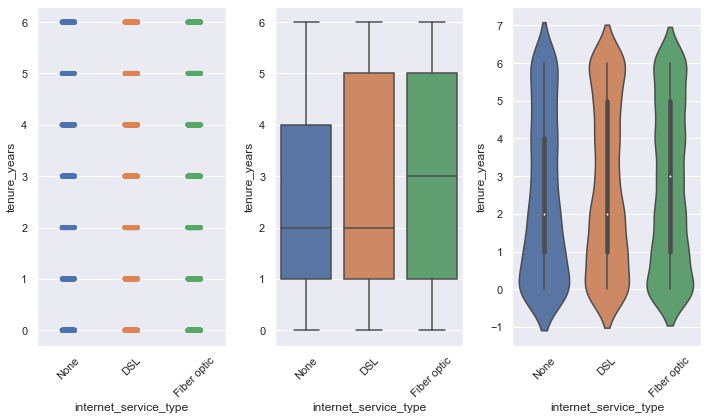

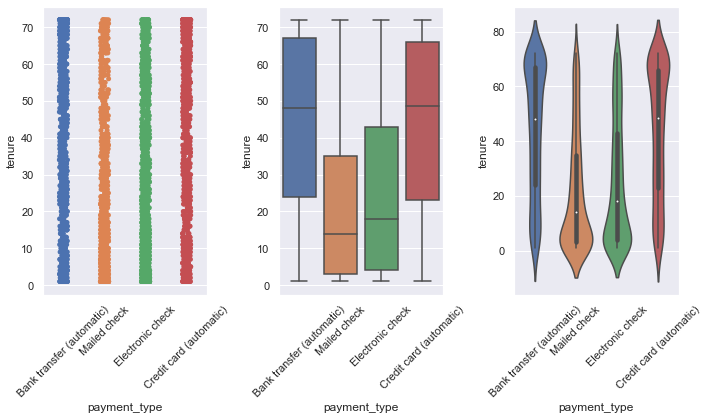

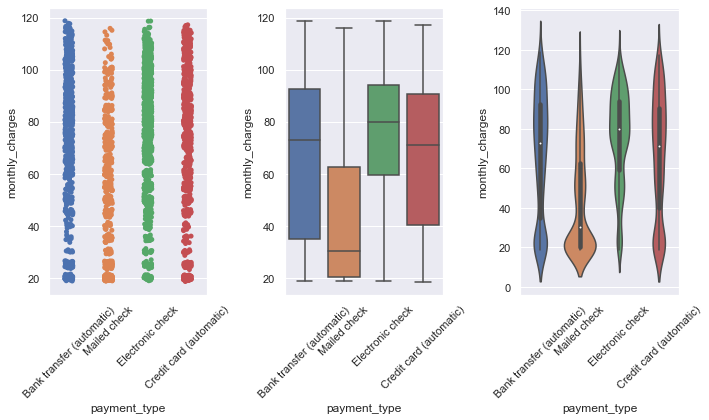

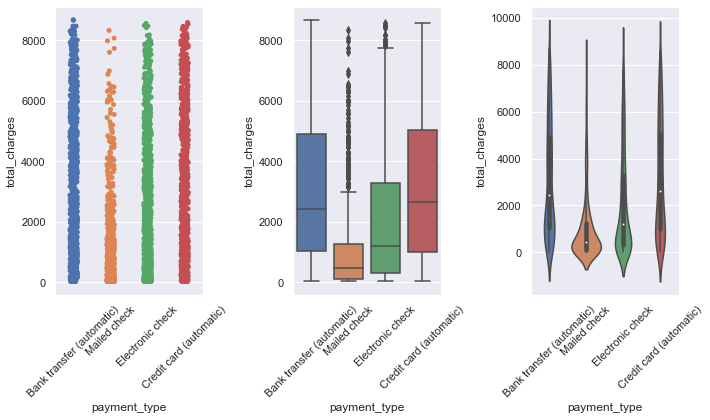

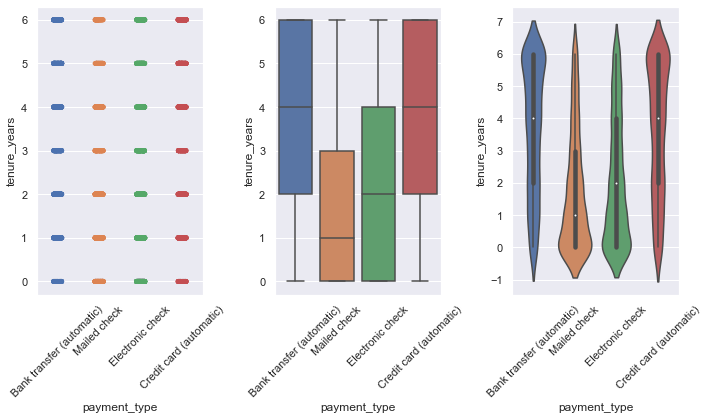

In [13]:
plot_categorical_and_continuous_vars(train, cat_cols, num_cols)

__Step 5__

Save the functions you have written to create visualizations in your explore.py file. Rewrite your notebook code so that you are using the functions imported from this file.

__Step 6__

Explore your dataset with any other visualizations you think will be helpful.

I will not be exploring any further, since we have already completed our telco project.

__Step 7__

In a seperate notebook, use the functions you have developed in this exercise with the mall_customers dataset in the Codeup database server. You will need to write a sql query to acquire your data. Make spending_score your target variable.

In the interest of time, I will not be doing this exercise. Instead, I'm going to begin working on the zillow data set since that's what our next project is over.

# Exercises - Part 2

As a Codeup data science graduate, you want to show off your skills to the Zillow data science team in hopes of getting an interview for a position you saw pop up on LinkedIn. You thought it might look impressive to build an end-to-end project in which you use some of their Kaggle data to predict property values using some of their available features; who knows, you might even do some feature engineering to blow them away. Your goal is to predict the values of single unit properties using the observations from 2017.

In these exercises, you will run through the stages of exploration as you continue to work toward the above goal.

__Step 1__

Use the functions you created above to explore your Zillow train dataset in your explore.ipynb notebook.

In [14]:
import wrangle
import prepare
import explore

In [15]:
#Acquire the zillow data
zillow = wrangle.wrangle_zillow()

In [16]:
#Split the data
train, validate, test = wrangle.train_validate_test_split(zillow)

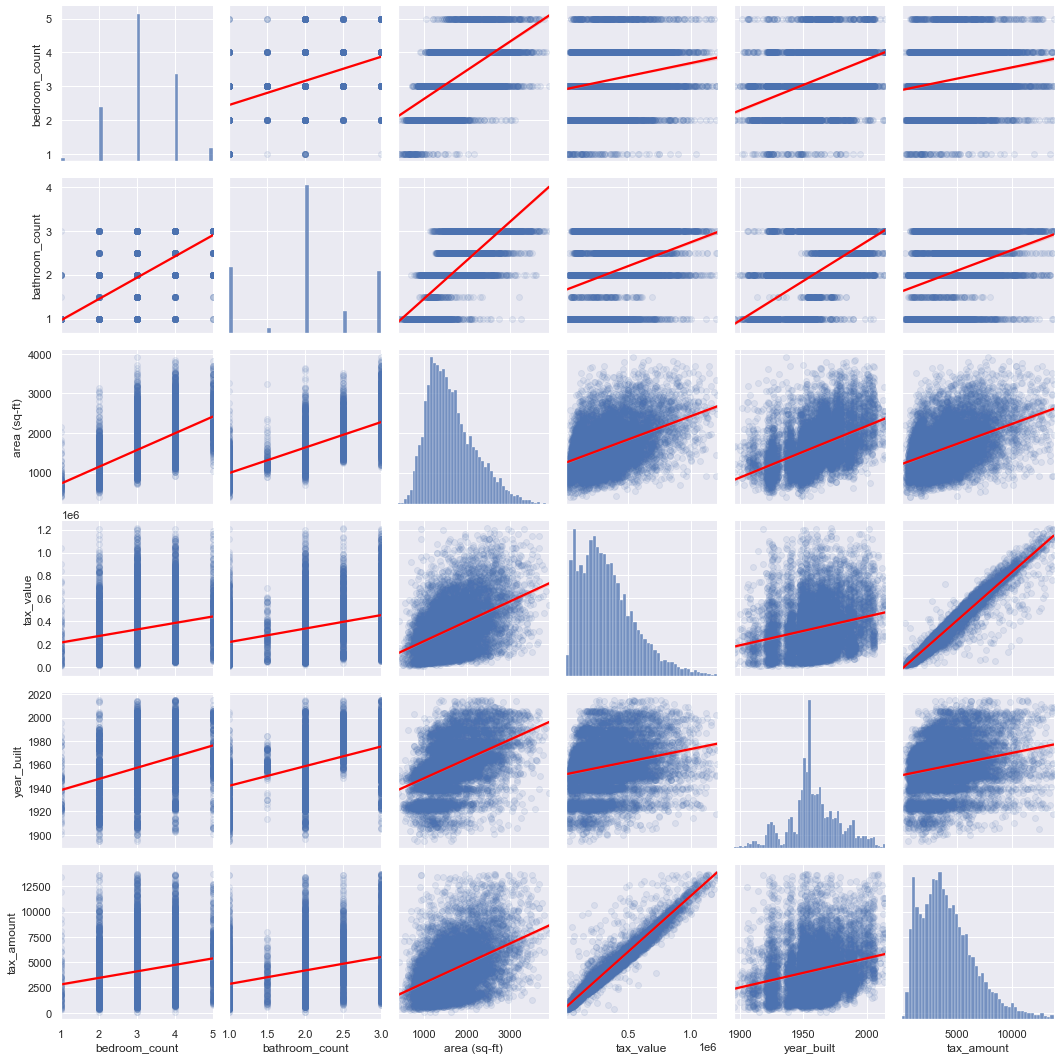

In [17]:
#Explore the train data
#Since there is so much data (about 2 million rows), I will only use a random sample of 10k
train_sample = train.sample(n = 10_000, random_state = 123)
explore.get_pairwise_charts(train_sample)

In [20]:
#Create lists of cat columns and numerical columns
cat_cols = ['fips']
num_cols = train_sample.select_dtypes('int').columns.append(train_sample.select_dtypes('float').columns)

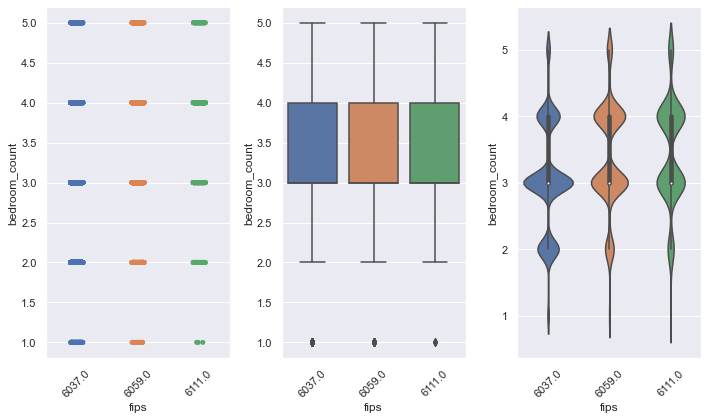

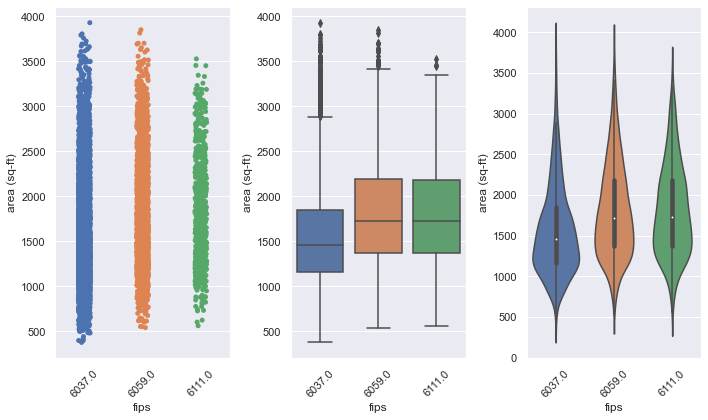

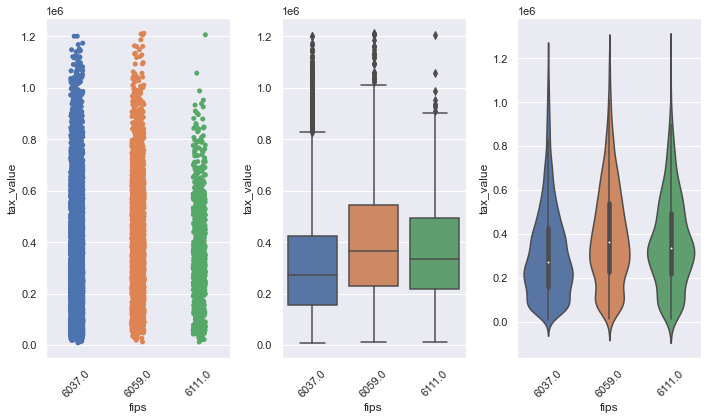

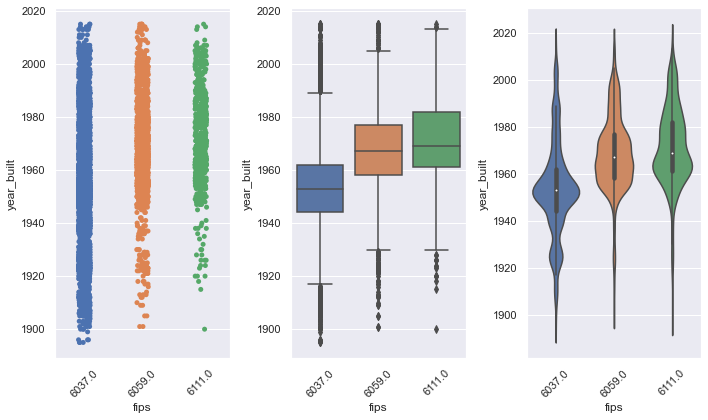

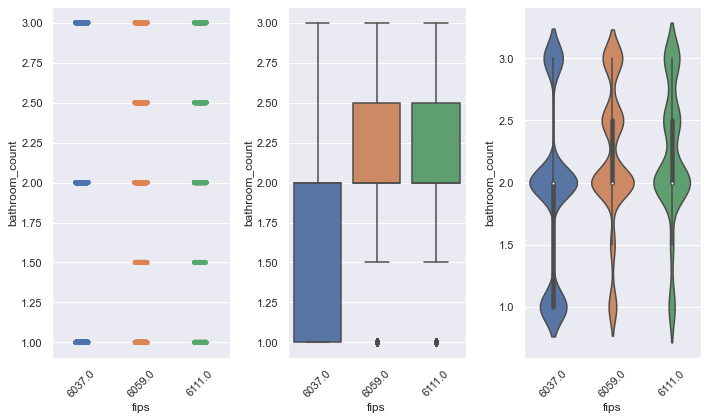

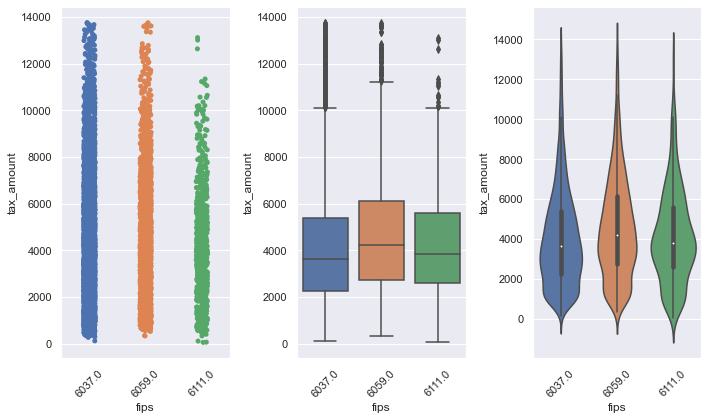

In [21]:
plot_categorical_and_continuous_vars(train_sample, cat_cols, num_cols)